## Background and Problem
When it comes to being more involved in the workforce, and finding a career or any job offer from promotion, it is important to see what influences salary as it is a critical problem in hiring decisions and modeling employee compensation. Employers want to ensure the salaries for different jobs are fair and want to make fair predictions to them. In terms of job-seekers, having  something useful for salary predicting, especially on future data, is useful in the sense where they want to understand what salaries depend on how they are affected. Fianlly for data analysts with a better understanding of seeing what impacts salary, they can use this knowledge to make improvments on the impact of education, job experience, and career. 

For this project, our data consists of around 376 samples and 6 features. Each of these samples contain a person's info about their educational background(Bachelors, Masters, or PhD), their gender, job title, years of experience they have under their current job, and their salary. 

**Project Goal**: We want to determine how effectively and accurately the salary can be predicted, especially when it comes to working with future data, based on different demographic features of people. We hope to accurately determine which particular features are relevant to determining salary. 

We can first approach this through Data Visualization where we can observe the trends in salary across different education levels, and job groups, as well as years of experience. These visuals will provide us valuable insight such as any patterns in average salary grouped by education level and job groups and how they compare to those of other education levels, and job groups. It will also help us see the relationship between salary and years of experience people have for their job. 

For predictive performance and modeling of the salary, we use two different methods: Linear Regression with exhaustive subset selection, as we are dealing with a small p or number of features, and Random Forest with bagging. We perform exhaustive subset selection with linear regression will be performed through a 10-fold cross validation, with the Mean Squared Error(MSE) as the performance metric. Through this, we can find the best model with a particular subset of features when it is working with unseen data. These features would be the most relevant features that enable this model to work best with future, unseen data while having the lowest prediction error. We also train a Random Forest Regressor Model with 10-fold cross validation to also predict the salary values using Mean Squared Error(MSE) as the performance metric to compare its performance to that of the best-fitted model we found through linear regression with exhaustive subset selection. By doing this, it allows us to to see if there was any information or data lost by the regresssion model we found, such as any non-linear relationships or interactions. Finally, we train a Random Forest Classifier model with 5-fold cross validation using ordered levels in ascending order of the categories as the output variable. This model will allows us to analyze the model's performance for how effectively it can predict the salary category for an employee, especially when working with unseen data. We do this through a confusion matrix and variable importance through mean decrease in Gini impurity. This analysis helps us identify the relevant features for salary classification through these ordered levels. 



To start we will import the necessary libaries

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from collections import defaultdict

## Loading the data
We need to load the data we are dealing with into a dataframe. The input data file is a csv file
We will use the read_csv function from pandas to read the data and create it as a DataFrame object


In [2]:
#Use the read csv to read the data in the csv file and load it into a DataFrame
#object using pandas
df = pd.read_csv("salary Data.csv", sep=',')
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
371,43.0,Male,Master's,Director of Operations,19.0,170000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


## Data Cleaning, Insertion, and Preprocessing
Before performing data visualization and predictive modeling, we first need to perform data cleaning to remove any columns that are not necessary for our data visualization and predictive modeling of salary. We will also perform data insertion by adding an additional column to the dataset, which contain those ordered level for the salary. These levels are created by dividing the salary range into five, equally-spaced ordered levels, which is vital to part of the pedictive modeling analysis.

We will first drop the age and gender column as they will not be used in our data analysis and visualization, and predictive modeling. 

In [3]:
#When predicting salary, the main important factors to predict would be education level, job title, and years of experience.
#We drop the age and gender columns completely from the dataframe 

df = df.drop(columns=['Age', 'Gender'])
df.head()

,Education Level,Job Title,Years of Experience,Salary
0,Bachelor's,Software Engineer,5.0,90000.0
1,Master's,Data Analyst,3.0,65000.0
2,PhD,Senior Manager,15.0,150000.0
3,Bachelor's,Sales Associate,7.0,60000.0
4,Master's,Director,20.0,200000.0


In [4]:
#Check for any null values in the data for all the columns
df.isnull().sum(axis=0)

Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

<br>
We notice there are two observations or rows in the dataset for each feature or column that contain
null values. Since we do not know the exact data for these null values, we would efectively drop them
from the dataset using the dropna function.
<br>

In [5]:
#Use dropna toremove the observations containing the identified null values from the dataframe
#We then check with isnull() to see if there are any additional null values in the dataframe remaining
df = df.dropna()
df.isnull().sum(axis=0)

Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

In [6]:
#Get the number of observations and number of features
df.shape

(373, 4)

<br>
We then perform data insertion of adding the salary category column containing those ordered levels of salary to the dataset. 
We first will create 5 different levels  for salary, each of which are equally split from the salary range in ascending order. 
From there, we classify the salary values into different cateogory levels based on the respective ranges for those categories a given salary falls under. 
Fianlly, we will add the new column to the dataset. 
<br>

In [7]:
#Use reset_index function to reset the DataFrame to using the default unique id schema where 
#For the first row, the first id is 0. 
df = df.reset_index(drop=True)
salaryCategory = []
nLevels = 5
#This will partition the salaries into 4 equally spaced regions where we include min salary value and the endpoints for each region.
levelRegions = np.linspace(min(df["Salary"]), max(df["Salary"]), nLevels+1)
print(levelRegions)
numRows = df.shape[0]

for i in range(0, numRows):
    curLevel = 1
    for j in range(0,len(levelRegions) - 1):
        maxPoint = levelRegions[j+1]
        if df['Salary'][i] >= levelRegions[j] and df['Salary'][i] < maxPoint:
            break
        curLevel += 1
    salaryCategory.append(curLevel)

[   350.  50280. 100210. 150140. 200070. 250000.]


In [67]:
#Add the 'salaryCategory' array as a column to the dataset where the name of 
#that new column will be 'Salary Category'
df['Salary Category'] = salaryCategory
df.head()

,Education Level,Job Title,Job Group,Years of Experience,Salary,Salary Category
0,Bachelor's,Software Engineer,Software / IT,5.0,90000.0,2
1,Master's,Data Analyst,Data / Analytics,3.0,65000.0,2
2,PhD,Senior Manager,Operations / Management,15.0,150000.0,3
3,Bachelor's,Sales Associate,Marketing / Sales,7.0,60000.0,2
4,Master's,Director,Executive / Leadership,20.0,200000.0,4


<br>
In the dataset, there are about 174 different jobs, where these jobs can be different variations of some job category. Additionally dealing with many jobs can make the data complex, leading to a lot of noise in the data. 

Hence, we would have to preproces the data where we will include a new column in the dataset containing different job categories where there will be one job category for each observation in the data. The job category assigned depends on specific keywords related to it and for each observation in the data, if the job in the "Job Title" column has specific keywords related to a job category, the observation is given that job category in the new column. 

This contains all the possible keywords for each identified job group of all the distinct job titles. 
There were many identified distinct jobs in the dataset. Hence to ensure there is no possible noise and improve interpretability,
we classify the different jobs into their respective job category bassed on the keywords it has. By doing so ,we are preprocessing the data where each observation will have
job category based on the value in the Job Title column

<br>

In [9]:

job_groups = {
    "Software / IT":[
        "software", "developer", "engineer", "it", 
        "network", "technical", "tech", "architect", "support"
    ],
    "Data / Analytics": [
        "data", "analyst", "analytics", "business intelligence", "bi", 
        "scientist", "researcher"
    ],
    "Marketing / Sales": [
        "marketing", "sales", "account", "advertising", "social media", 
        "public relations", "brand", "business development", "copywriter"
    ],
    "Human Resources": [
        "hr", "recruit", "human resources", "talent", "people"
    ],
    "Finance / Accounting": [
        "finance", "financial", "account", "accountant", "advisor", "auditor"
    ],
    "Operations / Management": [
         "operations", "manager", "management", "supply chain", "coordinator", "logistics", "consultant", "strategy"
    ],
    "Customer Service / Support": [
       "customer", "support", "help desk", "success"
    ],
    "Creative / Design": [
        "designer", "creative", "ux", "graphic", "content", "copywriter", "producer"
    ],
    "Product / Project": [
        "product", "project", "program"
    ],
    "Science / Research": [
        "scientist", "research", "laboratory", "principal scientist", "researcher"
    ],
    "Executive / Leadership": [
        "director", "chief", "vp", "executive", "ceo", "president"
    ],
    "Administrative / Support": [
        "assistant", "administrative", "clerk", "office", "coordinator", "specialist", "rep"
    ]
}



<br>
With our dictionary of the different possible job categories and their common keywords in different job titles, 
We would go through each observation in the data frame and analyze the different job titles. Based on the keywords a specific job title within a particular observation contains,
if there is a keyword it contains that is within the set of keywords for a specific job group, that observation the specifc job title is in will contain 
that specific job group in the "Job Group" column when we add that column to the dataset. For now, it will be stored in an array where the elements will be stored in order by the unique index number or id of the observations in the dataset to ensure we have the correct job group for the job title for each observation. 
<br>

In [10]:
#For each observation/row in the dataset, we will get the value in the "Job Title" column. We see if any of the words within
#that value are keywords of a specific job category where any word of that job title is within the list of keywords for 
#a job category, which is a key in the "job_groups" dictionary. 
#If so, we append that job category to the jobGroupClass list. 
jobGroupClass = []
for i in range(0, numRows):
    curJob = df['Job Title'][i]
    if any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Software / IT']):
        jobGroupClass.append("Software / IT")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Data / Analytics']):
        jobGroupClass.append("Data / Analytics")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Marketing / Sales']):
        jobGroupClass.append("Marketing / Sales")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Human Resources']):
        jobGroupClass.append("Human Resources")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Finance / Accounting']):
        jobGroupClass.append("Finance / Accounting")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Operations / Management']):
        jobGroupClass.append("Operations / Management")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Customer Service / Support']):
        jobGroupClass.append("Customer Service / Support")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Creative / Design']):
        jobGroupClass.append("Creative / Design")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Product / Project']):
        jobGroupClass.append("Product / Project")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Science / Research']):
        jobGroupClass.append("Science / Research")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Executive / Leadership']):
        jobGroupClass.append("Executive / Leadership")
    elif any(jobKey.lower() in curJob.lower() for jobKey in job_groups['Administrative / Support']):
        jobGroupClass.append("Data / Analytics")


In [11]:
#We insert the array of job groups in the dataset 
df.insert(loc=2, column = 'Job Group', value = jobGroupClass)
df.head()

,Education Level,Job Title,Job Group,Years of Experience,Salary,Salary Category
0,Bachelor's,Software Engineer,Software / IT,5.0,90000.0,2
1,Master's,Data Analyst,Data / Analytics,3.0,65000.0,2
2,PhD,Senior Manager,Operations / Management,15.0,150000.0,3
3,Bachelor's,Sales Associate,Marketing / Sales,7.0,60000.0,2
4,Master's,Director,Executive / Leadership,20.0,200000.0,4


## Data Visualization
After cleaning up the data and inserting our salary category level column, we can now perform Data visualization where we analyze how the  features of education and job groups and years of experience are related to the target variable, in this case salary. 

By observing the average salaries per education level and each job group as well as the relationship between salary and years of experience, it will help us identify any key trends in the dataset. These observations will be beneficial to our predictive modeling when finding the best models for effectively predicting salary, especially when it works with future data, as well as which features are likely to be more important in salary prediction. It will provide us with expectations of seeing the potential relevant features as well as explaining why some models or subsets of features for a best performing model will perform better in making predictions of the salary or salary category level in terms of MSE and accuracy. 

In [12]:
#The two lists below are used to store the mean salaries for each unique value
#for the education levels and job groups. 
avgSalaryByEducation = []
avgSalaryByJob = []
edCategories = df['Education Level'].unique()
jobCategories = df['Job Group'].unique()

#We go through each of the different unique education levels in the 'Education Level' column
#where we would get the mean of the salary values grouped by each value in the 'Education Level' column
for curEd in edCategories:
    avgSalaryByEducation.append(mean((df[df['Education Level'] == curEd])['Salary']))

#We go through each of the different unique job categories in the 'Job Group' column 
#where we  would get the mean of the salary values grouped by each value in the 'Job Group' column. 
for curJob in jobCategories:
    avgSalaryByJob.append(mean((df[df['Job Group'] == curJob])['Salary']))

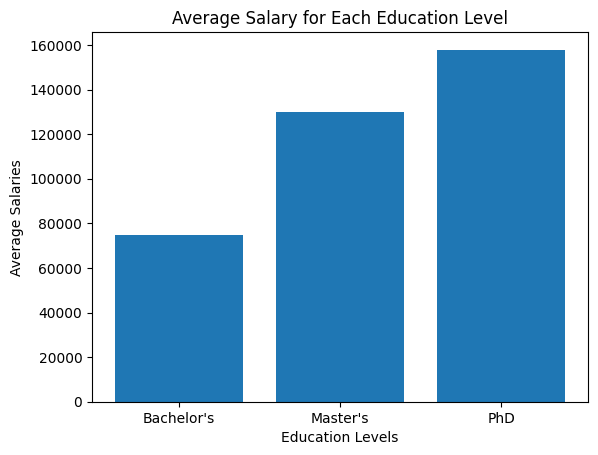

In [13]:
#Creates a bar plot of the mean salaries of each education level
plt.bar(edCategories, avgSalaryByEducation)
plt.xlabel("Education Levels")
plt.ylabel("Average Salaries")
plt.title("Average Salary for Each Education Level")
plt.show()

Based on the Barplot above, we can see a postitive trend where with a higher education background, the average salaries of jobs requiring  a higher education background increases. We see average salary of jobs requiring Masters degree is higher than that of jobs requiring Bachelors degree and the average salary of jobs requiring a PhD degree is higher than that of jobs requiring Masters degree. 

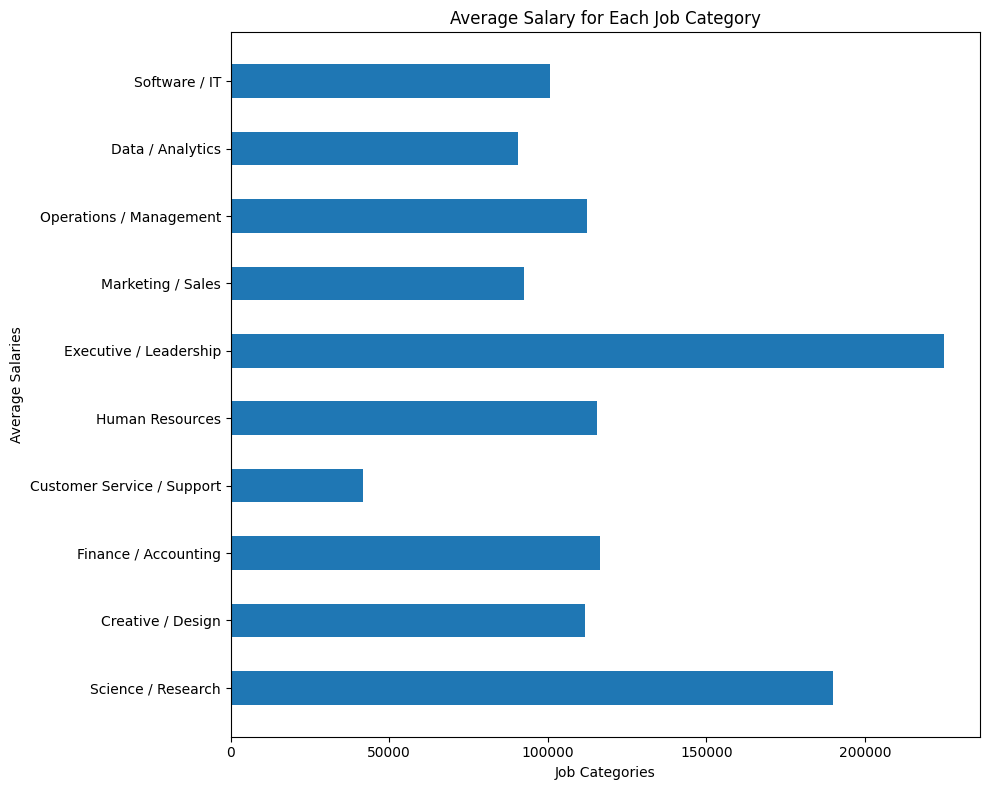

In [14]:
#Creates a horizontal bar plot of the mean salaries for each job group
plt.figure(figsize = (10,8))
plt.barh(jobCategories, avgSalaryByJob, height = 0.5)
plt.xlabel("Job Categories")
plt.ylabel("Average Salaries")
plt.title("Average Salary for Each Job Category")

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

We now want to observe any trends in the data between the job experience and salary. Since we have numerical data for both features, we can visualize these features using a scatter plot to see if there is a definitive relationship between job experience and salary

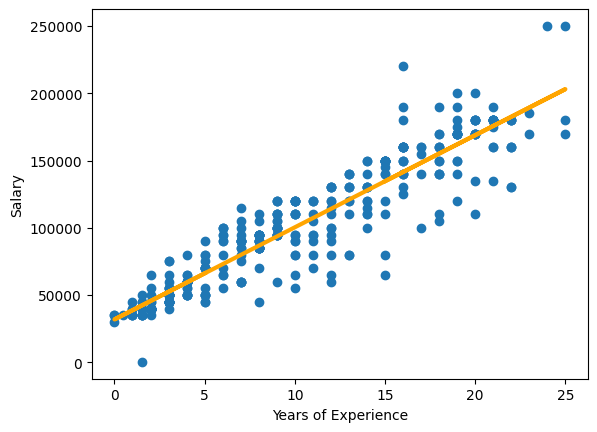

In [15]:
yearsOfExperience = df["Years of Experience"]
salaryValues = df["Salary"]
x=yearsOfExperience
y=salaryValues
z_line = np.polyfit(yearsOfExperience,salaryValues,1)
p = np.poly1d(z_line)
plt.scatter(x=yearsOfExperience, y=salaryValues)
plt.plot(x, p(x), color="orange", linewidth=3)
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

Based on the scatter plot above, we can see a strong correlation between salary and years of experience where there is a positive linear relationship between the two. Hence, we can expect that years of experience could potentially be a important factor in predicting the salary or salary categories for an employee. Even though the relationship is not purely linear, we still we a strong positive linear relationship as it is closely linear. 

## Data Pre-Processing through Encoding Categorical Columns
In this section we will apply methods of Data Encoding to prepare the data for train test splitting, which will be used for linear regression with exhaustive subset selection.  
We need to ensure the features are all numerical in a reasonable way as Linear Regression expects the features consist of numerical values. In terms of Random Forest Regressor Model, we will also need to encode the categorical features numerically where for a split on a node, there is no specific ordering or magnitude of the values for job group and education level. Hence, we would need to treat the cateogries as unordered, but different groups with numerical values as thereis no nominal ordering for them. 

To address these issues, we will apply the one Hot Encoder technique where for the categorical features involved in the dataset, Education Level and Job Groups since thesefeatures contain more than 2 unique values. 

By using the One Hot Encoder technique, we encode the values of these features where we would take each unique value within the Education Level and Job Groups columns and create individual columns of them we would include in another dataframe where each column would have encoded values of 0.0 or 1.0. 

We would then add the "Years of Experience" and "Salary" columns to this other dataframe, which we will use going forward when performing linear regression with exhaustive subset selection and creating our Random Forest Regressor model. 


In [16]:
#Creates a oneHotEncoder object that encodes all values of all categorical columns while not converting output to a matrix. 
encoder = OneHotEncoder(sparse_output = False, handle_unknown= 'ignore')

#apply fit_transform after encoding values of a column on the categorical columns and take the result and conveert it to a dataframe
categoricalEncode = encoder.fit_transform(df[['Education Level', 'Job Group']])
regressionDf = pd.DataFrame(categoricalEncode, columns=encoder.get_feature_names_out(['Education Level', 'Job Group']))

# take the values from the numeric columns, 'Years of Experience' and 'Salary' and add those to the revised Dataframe
regressionDf['Years of Experience'] = df['Years of Experience']
regressionDf['Salary'] = df['Salary']
regressionDf

,Education Level_Bachelor's,Education Level_Master's,Education Level_PhD,Job Group_Creative / Design,Job Group_Customer Service / Support,Job Group_Data / Analytics,Job Group_Executive / Leadership,Job Group_Finance / Accounting,Job Group_Human Resources,Job Group_Marketing / Sales,Job Group_Operations / Management,Job Group_Science / Research,Job Group_Software / IT,Years of Experience,Salary
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,90000.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,65000.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.0,150000.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,60000.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,85000.0
369,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19.0,170000.0
370,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,40000.0
371,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,90000.0


For Random Forest Classification, we will need to encode the categorical features numerically, but using a different encoding method. In a Random Forest Classifier, the splits in the trees in the Random forest do not treat the encoded values as numerical quantities. Instead, they check whether something is classified as a specific category where the number encoding represents that category, instead of using the numerical values as numerical quantities. 

For this, we can use Label encoding where we encode categorical features numerically, but those numbers are not quantities. These numerical encoddings are not based on any nominal ordering.  Each number for a specific feature is a simply an encoding  representing a unique value, which is a string, for that feature.

In [62]:
randomForestDf = df.drop(columns=["Job Title", "Salary"])
#print(len(randomForestDf["Job Group"].unique()))
le_education = LabelEncoder()
le_job = LabelEncoder()
le_salary = LabelEncoder()
randomForestDf["Education Level"] = le_education.fit_transform(randomForestDf["Education Level"])
randomForestDf["Job Group"] = le_job.fit_transform(randomForestDf["Job Group"])
randomForestDf.head()

,Education Level,Job Group,Years of Experience,Salary Category
0,0,9,5.0,2
1,1,2,3.0,2
2,2,7,15.0,3
3,0,6,7.0,2
4,1,3,20.0,4


## Prepping Data for Train Test
Now with the data finally being cleaned and clearly preprocessed, we can then go ahead and split the data into training and testing sets and then splot the features into X and y where X has group of features and y contains the target variable, which is the salary. 

To split the data into training and testing, we will first want to take all the data, but in random order where we are shuffling the dataset. From there we will then get the last index of the data for the training set by taking the length of the dataset and since we are spliting it to 80% training and 20% testing, we multiply the length of the dataset by 0.8 to get the index. 

Finally we will assign the training all the rows from index 0 to the index at length of the dataset times 0.8 and the remaining rows are assigned to the test dataset.

In [18]:
# We want to split the data into training and testing data
#Randomize the data using regressionDf.sample function and get the index of the last row of the training
#set which is the index length of the dataframe times 0.8
data_randomized = regressionDf.sample(frac = 1, random_state = 1)
training_set_index = round(len(regressionDf) * 0.8)

#Training set has 80% of the data and test set has 20% of the data
training_set = data_randomized[:training_set_index].reset_index(drop=True)
test_set = data_randomized[training_set_index:].reset_index(drop=True)

#Print the shapes of the training and testing sets
print(training_set.shape)
print(test_set.shape)

(298, 15)
(75, 15)


We split the features, which is assigned to X and target variable, which is assigned to y
X_train containing data from training set of the columns indexed from 0 to 13, X_test contains data from test set of the columns from 0 to 13. 
y_train contains data from training set of the column as the target variable, in this case "Salary." y_test contains data from test set of the column as the target variable. 

In [19]:
#X_train is given the data from the training set containing all columns except for "Salary",
#X_test is given data from the test set containing all columns except for "Salary",
#y_train is given the data from training set containing only the values in the "Salary" column,
#y_test is given the data from the test set containing only the values in the "Salary" column
X_train = training_set.iloc[:,0:14]
X_test = test_set.iloc[:,0:14]
y_train = training_set['Salary']
y_test = test_set['Salary']

## Linear Regression with Exhaustive Subset Selection
We can now perform linear regression with exhaustive subset selection where we would first
create an empty Linear Regression model containing no features. 

From there, we apply the python Exhaustive Feature Selection function to perform exhaustive subset selection using that linear regression model. It will also perform 10-fold cross validation to reduce overfitting of the data. Through this, we will get the MSEs for each fold for each combination of features along with the average MSE values, which are the CV MSE values for each combination of features used. These MSE values though are negative values, but essentially we have 9 folds containing training data used to train the linear regression model we pass to EFS on the subset of features involved in that model. The other 1 fold is used for validation data, which is out-of-sample data that helps us see how well a model can predict salary while working on this out-of-sample data, which acts as unseen data. 

NOTE: This does not include the "Salary" column as that is the target variable. 

In [20]:
#We create a Linear Regression model containing null features
linReg = LinearRegression()

In [21]:
#We use the Exhaustive subset set function in python from mlextend with 10-fold cross validation
#By using MSE as the performance metric, it evaluates the performance error of a model, which tells us how
#far the model's predictions on salary when tested on unseen data, which is the validation data. 
exhaustive = EFS(linReg, min_features=1, max_features=14, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
efs = exhaustive.fit(X_train, y_train)



Features: 5635/16383IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Features: 9350/16383IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Features: 13358/16383IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_wind

In [22]:
#We sort the dictionary by the values of the keys, which are numerical starting from 0. 
from itertools import islice
r2Results = dict(sorted(efs.get_metric_dict().items()))
dict(islice(r2Results.items(), 2))

{0: {'feature_idx': (0,),
  'cv_scores': array([-9.84288866e+08, -1.18864614e+09, -1.20161334e+09, -1.12765022e+09,
         -1.22203269e+09, -1.31341396e+09, -1.15317413e+09, -1.80266538e+09,
         -7.15749599e+08, -1.21727787e+09]),
  'avg_score': np.float64(-1192651220.0423412),
  'feature_names': ("Education Level_Bachelor's",),
  'ci_bound': np.float64(191513486.34072506),
  'std_dev': np.float64(257856667.46733612),
  'std_err': np.float64(85952222.48911203)},
 1: {'feature_idx': (1,),
  'cv_scores': array([-2.24439151e+09, -2.03866068e+09, -2.14111259e+09, -1.64666725e+09,
         -2.04673529e+09, -1.98122312e+09, -1.74224419e+09, -2.27799266e+09,
         -1.57094265e+09, -1.96080575e+09]),
  'avg_score': np.float64(-1965077569.1337352),
  'feature_names': ("Education Level_Master's",),
  'ci_bound': np.float64(170284502.84404936),
  'std_dev': np.float64(229273641.57832423),
  'std_err': np.float64(76424547.19277473)}}

<br>
We now have to find all the best models for each value of k, which is from 1 to the total number of features, in this case 14. This range from 1-14 is the possible number of features, which is k, used on a model
These best models would be the models that contain the lowest MSE values for each value of k. 

We create a empty dictionary along with a list of all the k value and for each element in the dictionary generated from the EFS function in python,
we get the length of the tuple in the 'feature_idx' key, which is a particular k value, that contains the index of the features used in that model.
We append it to the list of MSE values for the key that has the same value as that particular k value. 

Finally, we go through all the different values of k, and for each one, we get the list of MSE values. Whichever one is the smallest MSE value within that list is the value of the best Model, Mk for that given value k. 
Since there are 14 values of k, we have 14 different best models for each value of k. 
<br>

In [23]:
kValues=list(range(1,15))
print("List of values for k: ", kValues)

mseDict = defaultdict()

for curDict in r2Results.values():
    featureLength = len(curDict['feature_idx'])
    if mseDict.get(featureLength, "None") == "None":
        mseDict[featureLength] = [-curDict['avg_score']]
    else:
        mseDict[featureLength].append(-curDict['avg_score'])
bestMSEValues = []
for curK in kValues:
    bestMSEValues.append(min(mseDict[curK]))
bestMSEValues

List of values for k:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


[np.float64(297983435.73296535),
 np.float64(238183161.87482285),
 np.float64(237180589.75740367),
 np.float64(236273088.67116088),
 np.float64(235242598.5414845),
 np.float64(235219677.3533845),
 np.float64(235219677.35338455),
 np.float64(235219677.3533848),
 np.float64(235782545.96133232),
 np.float64(235972538.97072506),
 np.float64(236828009.1608255),
 np.float64(237878810.57622367),
 np.float64(237979549.7730546),
 np.float64(239775316.3168531)]

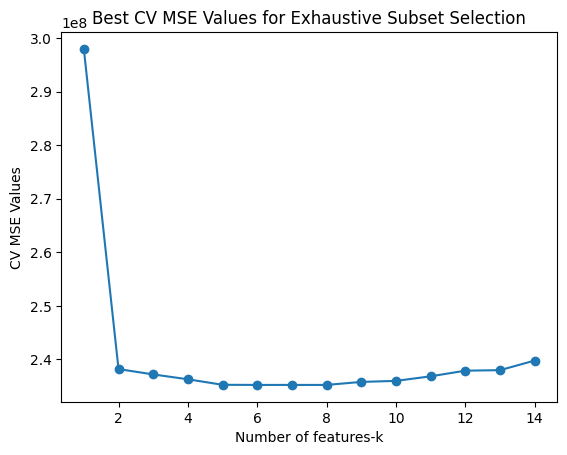

In [24]:
#We then create a plot to identify the best overall model used to accurately predict the salary where we can then get the best set of predictors for accurately predicting the salary
features = list(range(1, 15))
plt.plot(features, bestMSEValues, marker='o')
plt.xlabel("Number of features-k")
plt.ylabel("CV MSE Values")
plt.title("Best CV MSE Values for Exhaustive Subset Selection")
plt.show()

## Results for best model that could work well with future data
We will display the best MSE value or the lowest MSE value since the best model that could perform well while working with 
future data would have the smallest MSE value. In our case, it is the cross-fold MSE value since we used cross vold validation 
while performing exhaustive subset selection with linear regression using the MSE as the scoring value where in cross-fold validation
we would split the data into k folds where a fold contains validation data and the data that is not test data is training data. 

In [27]:
#Generates the best MSE value of the best model that can work with unseen data
bestMSEVal = efs.best_score_
#Generates the features part of the best model or the model with the least MSE value
bestFeatures = efs.best_feature_names_

print("Best MSE value of the best fitted model: ", -bestMSEVal)
print("Indexes of the best features: ", efs.best_idx_)   #Gets the indexes of the features that were part of the best model
print("Best set of predictors for accurately predicting the salary: ", bestFeatures)

Best MSE value of the best fitted model:  235219677.3533845
Indexes of the best features:  (0, 1, 6, 7, 10, 13)
Best set of predictors for accurately predicting the salary:  ("Education Level_Bachelor's", "Education Level_Master's", 'Job Group_Executive / Leadership', 'Job Group_Finance / Accounting', 'Job Group_Operations / Management', 'Years of Experience')


## Random Forest Regression
We wll provide a Random Forest regresssor model for predicting salary accurately and seeing if it is a better model to do so compared to the best model found in linear regression with exhaustive subset selection, especially when working on unseen data. We will use MSE as the performance metric and the same data set from the one-hot encoding as we are comparing numerical values withiin each node of the tree and using label encoding could introduce bias in the data. In our case there is no nominal order for the job groups or education levels, so label encoding is not suitable for this. 

We will use n_estimators =500 as we have tested this before with the Random Forest Classsifier model and found that to be the most accurate unlike 100, 200, and 300 trees. 

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
X = regressionDf.iloc[:, 0:14]
y = regressionDf["Salary"]

regressor_Rf = RandomForestRegressor(n_estimators=500, random_state= 42)
cvMSE = -1 * cross_val_score(regressor_Rf, X, y, cv=10, scoring = 'neg_mean_squared_error') 
best_MSE =  cvMSE.mean()
print("MSE value of the Random Forest Regressor Model: ", best_MSE)

MSE value of the Random Forest Regressor Model:  300016198.1624454


## Random Forest Classification

For building the Random Forest Classification model, We want to see which Random Forest classification model is the most accurate in predicting the salary category for employees by testing differet number of n_estimators. We will train Random Forest classification model with 100, 200, 300, and 500 n_estimators and in the end, the one with the highest accuracy score is the most effective and accurate Random Forest Classification Model for our task. 

For each Random Forest Classification model we build, we will be using 5-fold cross validation while shuffling the data. Cross validation is used since it is helpful for fine-tuning the hyperparameters of a random forest model, while also getting a more useful estimate of the model's performance on predicting salary categories, especially on future data.  

We will also split the data into train and test sets, but for each fold while performing cross validation on a Random Forest model. For now, we assign features used for making predictions to X and the target variable data, "Salary Category" to y. We will then make predictions on the test data for X and then for a particular fold, we will get a accuracy score that is evaluated on the test dataset. 

Finally after cross validation, we will take the sum of the acccuracy scores for all the folds of a Random Forest Classifier Model and take the average accuracy score, which will serve as the accuracy score of the Random Forest Classifier Model for a given number of n_estimators. 

In [30]:
X = randomForestDf.iloc[:, 0:3]
y = randomForestDf["Salary Category"]

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
n_estimators = [100,200,300, 500]
rf_models = []
accuracy_rfs = []
kFold = KFold(n_splits=5, shuffle=True, random_state=1)
for curEst in n_estimators:
    rf = RandomForestClassifier(n_estimators=curEst, random_state=1)
    foldAccuracyList = []
    for train_index, test_index in kFold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        foldAccuracyList.append(accuracy_score(y_test, y_pred))
    meanAccuracy = np.mean(foldAccuracyList)
    accuracy_rfs.append(meanAccuracy)
    rf_models.append(rf)
    print(f"Accuracy: {meanAccuracy} of random forest with {curEst} trees")

Accuracy: 0.7721081081081081 of random forest with 100 trees
Accuracy: 0.7694054054054054 of random forest with 200 trees
Accuracy: 0.7694414414414414 of random forest with 300 trees
Accuracy: 0.7748108108108107 of random forest with 500 trees


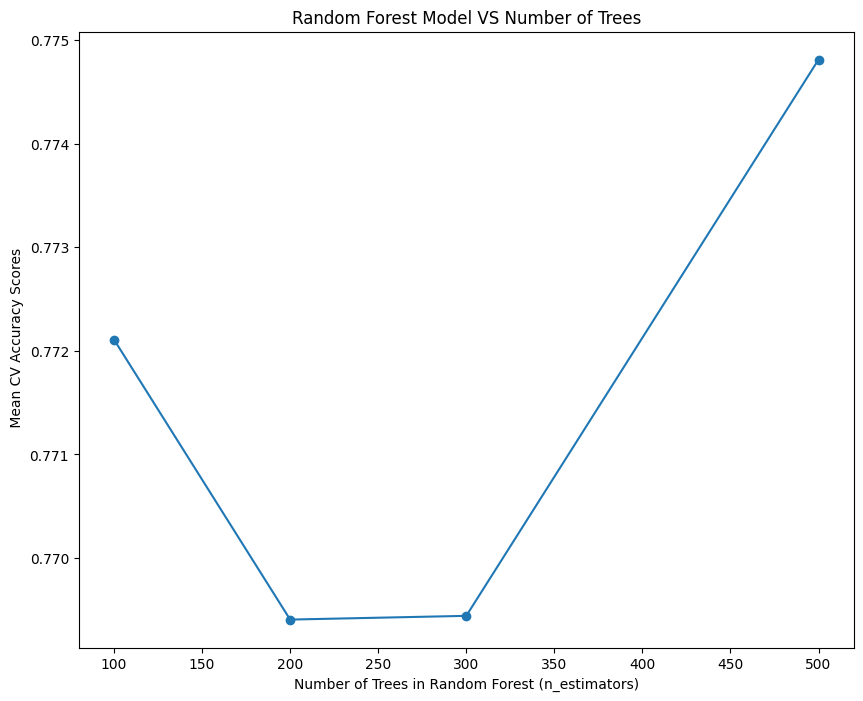

In [33]:
plt.figure(figsize = (10,8))
plt.plot(n_estimators, accuracy_rfs, marker='o')
plt.xlabel("Number of Trees in Random Forest (n_estimators)")
plt.ylabel(" Mean CV Accuracy Scores")
plt.title("Random Forest Model VS Number of Trees")
plt.show()


Based on the accuracy for the different random forests models we created out of different number of trees
We can see that the random forest model with 500 trees is the best performing random forest model as it has a higher mean accuracy Cross validation score of around 0.7748. Hence, that is our best performing Random Forest Classifier Model we can use for finding the most relevant features for salary classification of the different levels for salary in the Salary Category column. 

## Variable Importance
Since The Random Forest Classifier Model with 500 n_estimators had the highest accuracy, it is our most effective Random Forest Classifier model for predicting salary categories, which were divided into these 5 levels in the Salary Category column across the salary range. 

We can now perform variable importance to see which features is most relevant for an effective model for predicting the levels or salary categories for employees, especially when working on unseen data. 
We first create a Random Forest classifier model with 50 n_estimators and perform 5-fold cross validation while shuffling the data. We then create a confusion matrix, which will be used for easy comparison of the predicted salary category and actual salary category values. This will help us see how effective a model can distinguish between these different salary levels. 

In [40]:
best_rf = RandomForestClassifier(n_estimators=500, random_state=1)
kFold = KFold(n_splits=5, shuffle=True, random_state=1)
#We are using cross validation to create our predictions for y_pred since we used cross validation initially for train_test split when finding best RF model
y_predCV = cross_val_predict(best_rf, X, y, cv =kFold)
confusionMat = confusion_matrix(y, y_predCV)
confusionMat

array([[75, 11,  0,  0,  0,  0],
       [11, 96, 18,  0,  0,  0],
       [ 0, 18, 65, 13,  0,  0],
       [ 0,  0, 10, 53,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  1,  1,  0,  0]])

Based on the confusion matrix, we can see the Random Forest classifier model is accurately predicting the salary categories for the first 4 levels for the salary categories. However for the last 2 levels as the salary categories, the model is not effectively performing well on them as there is a small number of samples under those categories 

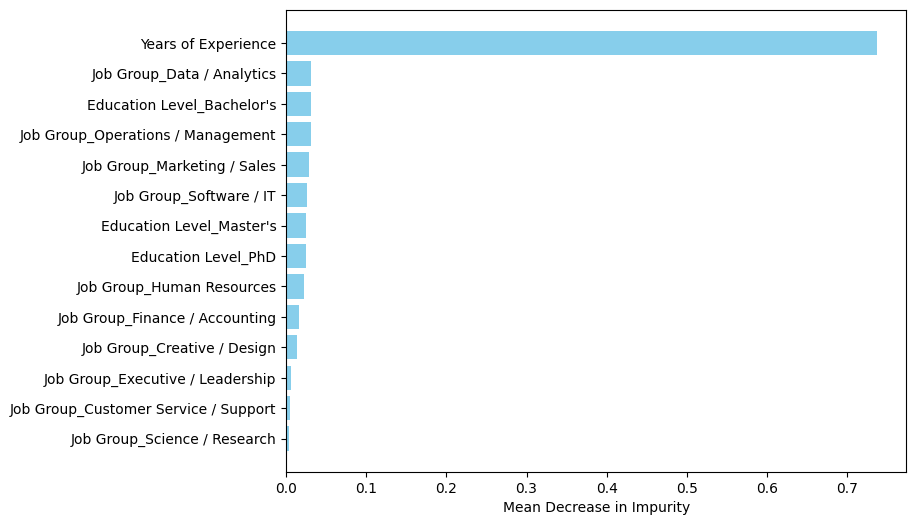

In [61]:
best_rf.fit(X, y)
importantFeatures = best_rf.feature_importances_
feature_names = X.columns
#We're getting an array of the indexes in ascending order by the mean gini index values 
indices = np.argsort(importantFeatures)
revImportances = [importantFeatures[curIndex] for curIndex in indices]
revFeatures = [feature_names[curIndex] for curIndex in indices]


plt.figure(figsize = (8,6))
plt.barh(revFeatures, revImportances, color = 'skyblue')
plt.xlabel("Mean Decrease in Impurity")
plt.show()

## Conclusion
Based on our analysis of the predictive modeling through linear regression with exhaustive subset selection, we can see the best model include the features at indexes 0,1,6,7,10,13 while achieving a Cross-fold MSE Score of 235219677.3533845. Based on this data, this tells us that the salary can be most accurately predicted when dealing with unseen data by the job groups at indexes 6,7,10 while having a bachelors and/or masters degree.

When comparing its performance to a Random Forest Regressor Model, we can see the Random Forest Regressor Model achieved a higher MSE score of 300016198.1624454. Since it had a higher MSE score, it performed worse than best fitted model of linear regression with exhaustive subset selection when predicting salaries, especially on unseen data. 


Even though the Random Forest Model did not outperform the best-fitted model for Linear Regression with exhaustive subset selections, random forests were able to provide us with more insight into variable importance in terms of finding the most relevant features that influence the salary predictions. Through the Random Forest classifier model, we noticed the Years of experience is the most significant feature, followed by Job Group Data/Analytics, and Bachelors Education level when it comes to predicting the salary categories(the 5 ascending levels that were equally split across the range of the salary)

Based on our results and gatherings, we can see that education and years of experience are probably the most relevant features influencing salary with linear regression being the most effective model in making predictions on salary, and Random Forests being the most effective model in finding these relevant features.

While it is interesting to see that Years of Experience was significantly more relevant compared to the other features and how the education levels were split into individual categories, one possible method of improving our analysis would be grouping the values of education into one one categorical value to see if there is an improvement in performance of the Random Forest models. We noticed the performance of the random forest model regressor was slightly worse than the linear regression with exhaustive subset selection. Additionally, I would like to see which number of levels for the salary categories would be more useful in finding a random forest model that can effectively predict salary categories by education, job group, and years of experience. 


## References
Dataset: https://www.kaggle.com/datasets/rkiattisak/salaly-prediction-for-beginer 

Exhaustive Subset Selection: https://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/#example-4-regression-and-adjusted-r2 

One Hot Encoding for Data Preprocessing: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html 

Random Forest Regressor: https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/

Feature Importance with Random Forests: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
